# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 1 threads 😎


In [2]:
# import Pkg
# Pkg.activate("../")
# Pkg.instantiate()


In [3]:
# import Pkg; Pkg.add(["Revise", "GLMakie"])

In [4]:
# using Revise
# using CellBasedModels
# using CUDA
# using Distributions
# using GLMakie
# # using GeometryBasics
# import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

In [5]:
import Pkg

# Activa el entorno del proyecto
Pkg.activate("../../../")

# Pkg.rm("GLMakie")

# Resuelve y asegura dependencias
Pkg.resolve()
Pkg.instantiate()

# Evita errores de versiones incompatibles forzando actualización
# Pkg.update(["CairoMakie", "Revise", "CUDA", "Distributions"])

# Carga los paquetes de forma ordenada
using Revise
using CellBasedModels
using CUDA
using Distributions
using CairoMakie
using JSON

# Importa funciones específicas después
import CairoMakie: Point3f, Cylinder, Sphere, NoShading

CairoMakie.activate!()


  Activating project at `c:\Users\julia\OneDrive\Escritorio\phd\Bacteria_ABM\ABM_CBM`
  No Changes to `C:\Users\julia\OneDrive\Escritorio\phd\Bacteria_ABM\ABM_CBM\Project.toml`
  No Changes to `C:\Users\julia\OneDrive\Escritorio\phd\Bacteria_ABM\ABM_CBM\Manifest.toml`


## Forces model

We already use the defined forces model that is implemented in CBqodels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [6]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
        ),    #Local Interaction Parameters

    model = Dict(
            :E=>Float64,
            :eta=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,d,l,theta,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,1,l,theta,
                        x[i2],y[i2],1,l[i2],theta[i2],eta, E)

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a coqunity with two bacteries and check forces

In [7]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );


#Natural units scales
m = 1.E3 #g
t = 1/(60*60) # h
d = 1.E6 #um


com.E=100. *m/(t^2*d)*1.E-3 #kPa
com.eta=500 *m/(t*d) #Pa h

com.d = 1.        
com.l = 3.99      



com.x = 0
com.y = 0
com.theta = 0;


In [8]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    com.l[i] = 3.0
    com.d[i] = 1.0

end

In [9]:
evolve!(com,steps=10000,saveEach=100,preallocateAgents=com.N)

In [10]:
function plotAgents2D!(ax, x, y, d, l, angle, p; colormap=:inferno, kargs...)
    for (xi, yi, li, di, ai, pi) in zip(x, y, l, d, angle, p)



            colorval = pi
            # colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )

    end
    return
end


plotAgents2D! (generic function with 1 method)

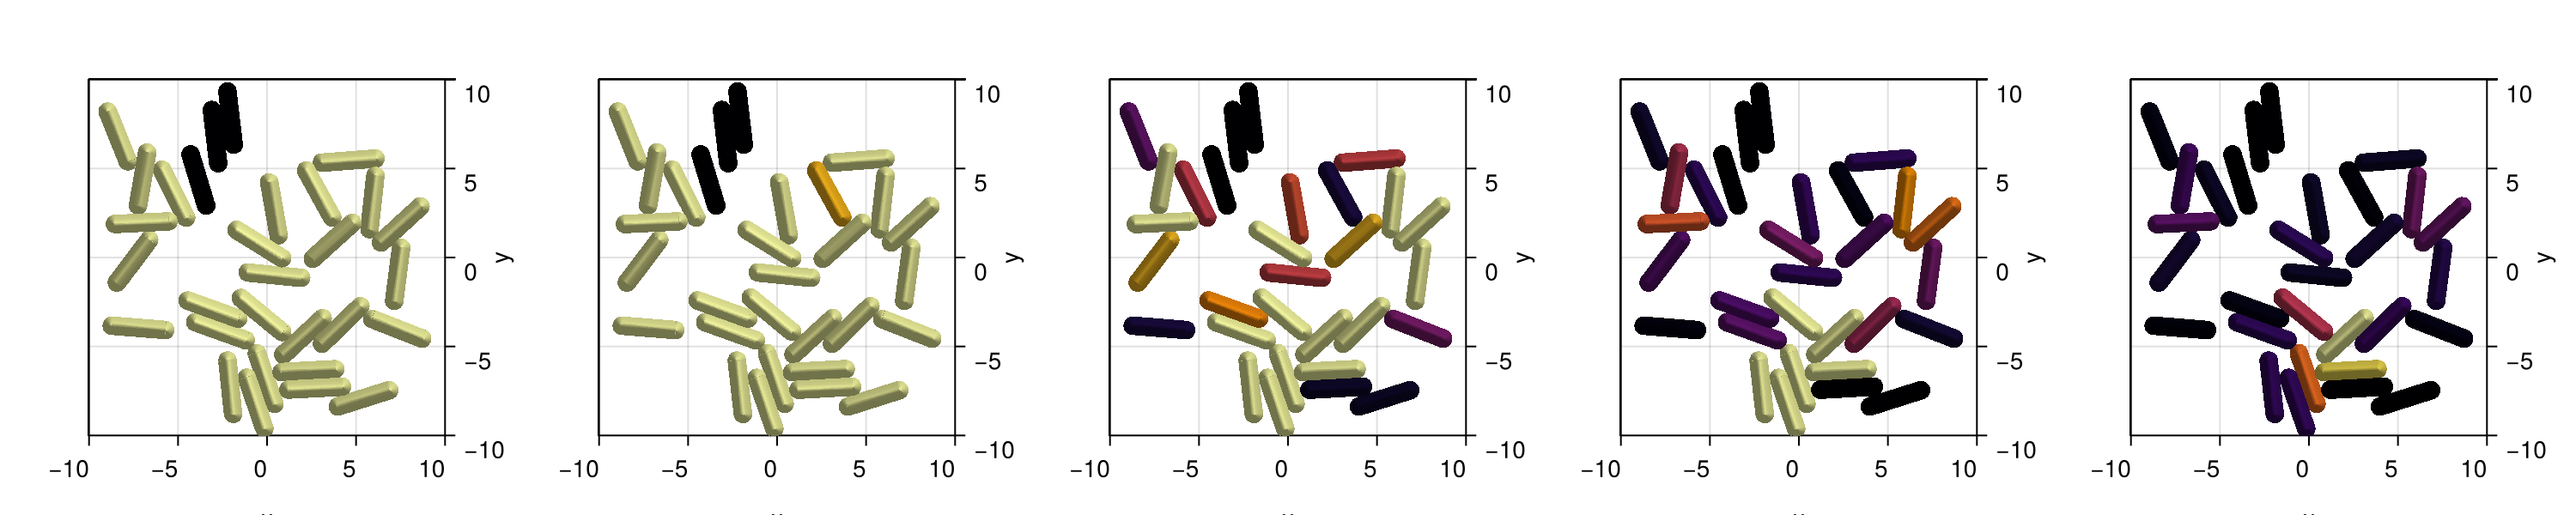

CairoMakie.Screen{IMAGE}


In [11]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

In [12]:

function log_community_state(parameters::OrderedDict, t::Int, path::String = "parameters_QS_cap.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_QS_cap.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [45]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :dg=> Float64, 
                :lTarget => Float64,
                :type => Int,
                :generation => Int,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :K_p=>Float64,
                :D_q => Float64,
                :delta_q => Float64,
                :alpha_q => Float64, 
                :beta_q => Float64,
                :K_q=>Float64,
                :alpha_H => Float64, 
                :K_qH=>Float64,
                :K_dH=>Float64,
                :delta_H => Float64,
            ),
    
    medium = Dict(
        :q => Float64,        #Add a medium parameter
    ),

 
    agentODE = quote    
        # dt(l) = l*growth  #linear growth with growth dependent on the pressure over the cell
        dt(l) = l*growth /(1+K_p*pressure) #linear growth with growth dependent on the pressure over the cell
        dt(dg) =  alpha_H * q^4/(K_qH^4+q^4) - delta_H*dg #linear growth with growth dependent on the pressure over the cell

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,dg+d,l,theta,
                                    x[i2],y[i2],dg[i2]+d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij
            
            pressure += sqrt(Fijx^2+Fijy^2)

            
        end
        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-1,1)*1.E-3 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget),
                    dg=sqrt((l-d)^2+dg^2+4*dg*l)-(l-d),
                    generation = generation + 1,)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    dg=sqrt((l-d)^2+dg^2+4*dg*l)-(l-d),
                    generation = generation + 1,)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing qs with a saturating function
        
        q += (alpha_q + beta_q*q^4/(K_q^4 + q^4))*dt
        

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(q) = D_q*(@∂2(1,q)+@∂2(2,q)) - delta_q*q 

        elseif @mediumBorder(1,-1)
            q = 0
        elseif @mediumBorder(1,1)
            q = 0 #Oscillatory behaviour
        elseif @mediumBorder(2,-1)
            q = 0
        elseif @mediumBorder(2,1)
            q = 0
        end

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

In [35]:
function plotMixedAgents2D!(ax, x, y, d, l, angle, type, p; kargs...)
    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)


        if ti== 0  # rods
            # colorval = pi
            # colormap = :Blues
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [:blue],
                # colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [:blue],

                # colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [:blue],

                kargs...
            )
        else  # puntos
            colorval = pi
            colormap = :Reds
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [:red],
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [:red],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [:red],
                colormap = colormap,
                kargs...
            )
        end

    end
    return
end


plotMixedAgents2D! (generic function with 1 method)

## Grow colony from one cell

In [36]:
1.E-3 /t 

3.6

In [37]:
1.E-13 *d^2/t

360.0

In [223]:
com.simBox

2×2 Matrix{Float64}:
 -100.0  100.0
 -100.0  100.0

In [194]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.0001,
            simBox = [-100 100;-100 100.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E3 #g
t = 1/(60*60) # h
d = 1.E6 #um


com.E=6* 1.E5 *m/(t^2*d) #Pa
com.eta=150 *m/(t^2*d) #Pa h

# com.D_q = 1.E-11 *d^2/t #m^2/s
com.D_q = 1.E-13 *d^2/t #m^2/s

com.alpha_q = 2 #nM /h
com.delta_q = 0.1 #1/h
com.beta_q = 100 #1/s
com.K_q = 5


com.dg=0.
com.alpha_H = 10000.
com.K_qH = 40.  
com.delta_H = 1000.  

com.growth = 1.
com.lMax = 4.     
com.K_p = 0.1     
com.σlTarget = 1. 
com.generation = 0 
 
com.d = 1.        
com.l = 3.99      
com.lTarget = 4.  
# com.v = 2.E-2 


com.x = 0
com.y = 0
com.theta = 0;

In [195]:
Int(round(2/com.dt))

20000

In [196]:
steps=Int(round(8/com.dt))
# saveEach=steps/100
saveEach=Int(round(10/com.dt))/100
# steps=100000
# saveEach=10000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_cap.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


Step 1000 N: 2
Step 2000 N: 2
Step 3000 N: 2
Step 4000 N: 2
Step 5000 N: 2
Step 6000 N: 2
Step 7000 N: 2
Step 8000 N: 2
Step 9000 N: 2
Step 10000 N: 3
Step 11000 N: 3
Step 12000 N: 3
Step 13000 N: 4
Step 14000 N: 4
Step 15000 N: 4
Step 16000 N: 4
Step 17000 N: 4
Step 18000 N: 4
Step 19000 N: 5
Step 20000 N: 5
Step 21000 N: 6
Step 22000 N: 7
Step 23000 N: 7
Step 24000 N: 8
Step 25000 N: 8
Step 26000 N: 8
Step 27000 N: 8
Step 28000 N: 8
Step 29000 N: 8
Step 30000 N: 8
Step 31000 N: 9
Step 32000 N: 10
Step 33000 N: 11
Step 34000 N: 15
Step 35000 N: 16
Step 36000 N: 16
Step 37000 N: 16
Step 38000 N: 16
Step 39000 N: 17
Step 40000 N: 17
Step 41000 N: 19
Step 42000 N: 23
Step 43000 N: 27
Step 44000 N: 29
Step 45000 N: 30
Step 46000 N: 32
Step 47000 N: 32
Step 48000 N: 32
Step 49000 N: 33
Step 50000 N: 33
Step 51000 N: 36
Step 52000 N: 39
Step 53000 N: 42
Step 54000 N: 43
Step 55000 N: 44
Step 56000 N: 47
Step 57000 N: 52
Step 58000 N: 54
Step 59000 N: 55
Step 60000 N: 58
Step 61000 N: 59
Ste

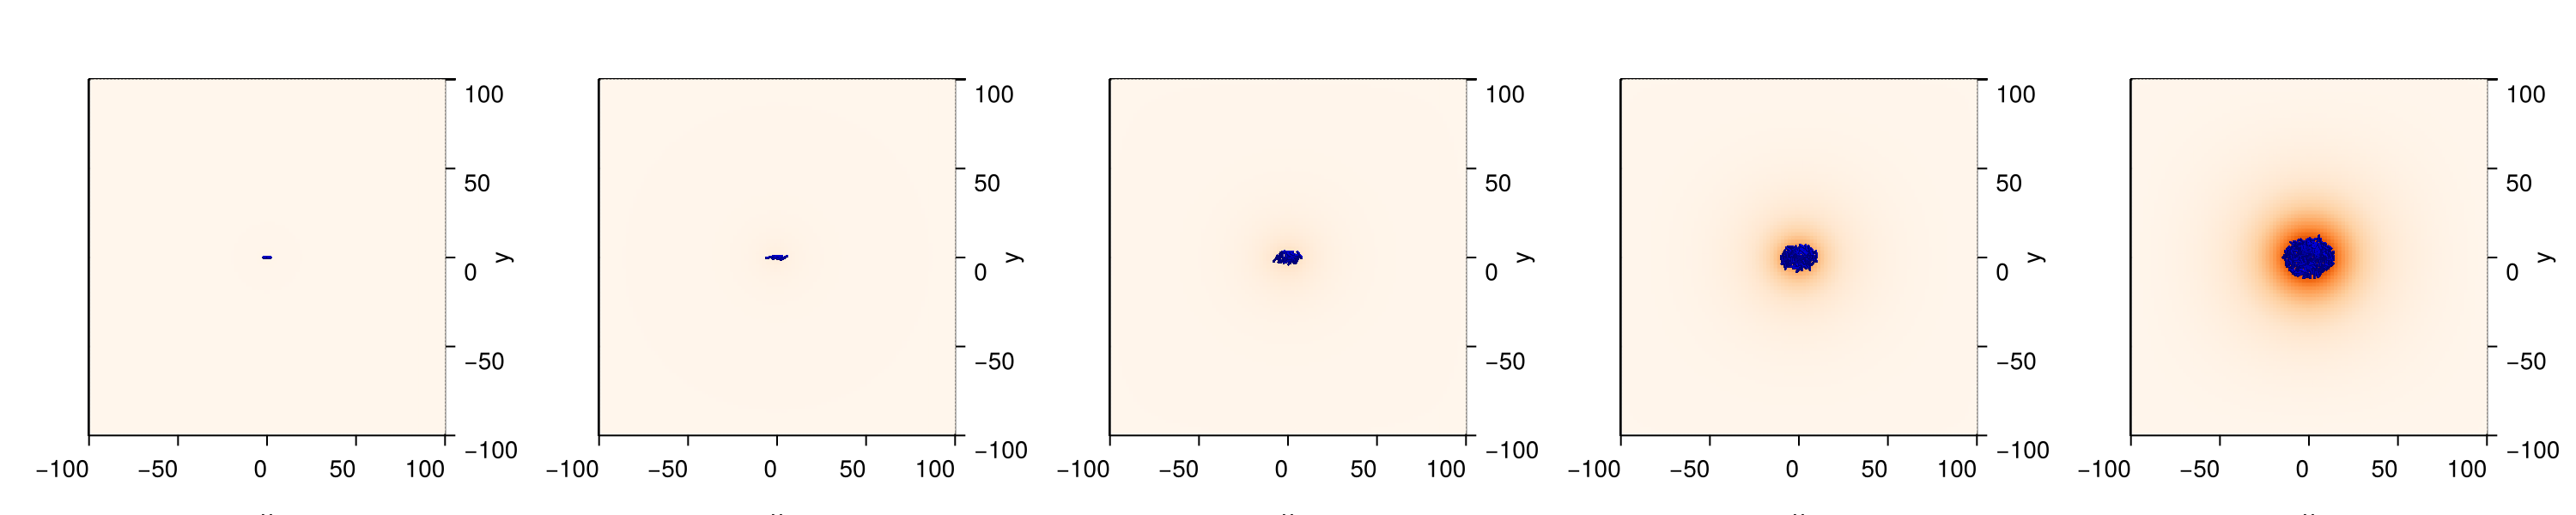

CairoMakie.Screen{IMAGE}


In [197]:
com_load,times=load_parameters_log("parameters_QS_cap.txt")
colormap=:Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotMixedAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

display(fig)

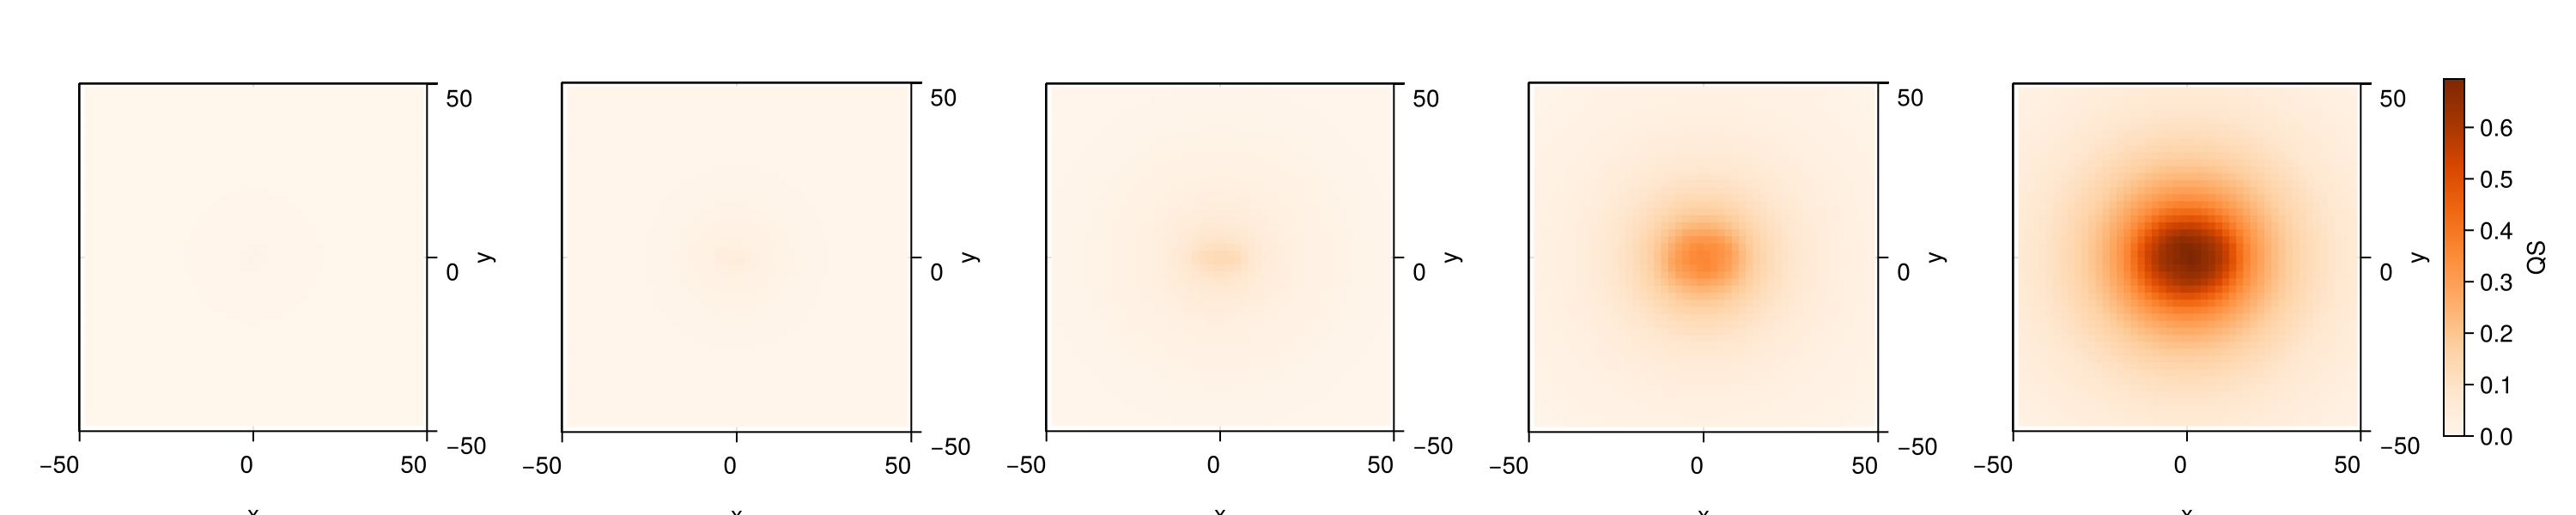

CairoMakie.Screen{IMAGE}


In [198]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:dg],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:dg],
    # colormap=:Blues,
    # colorrange = colorrange
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

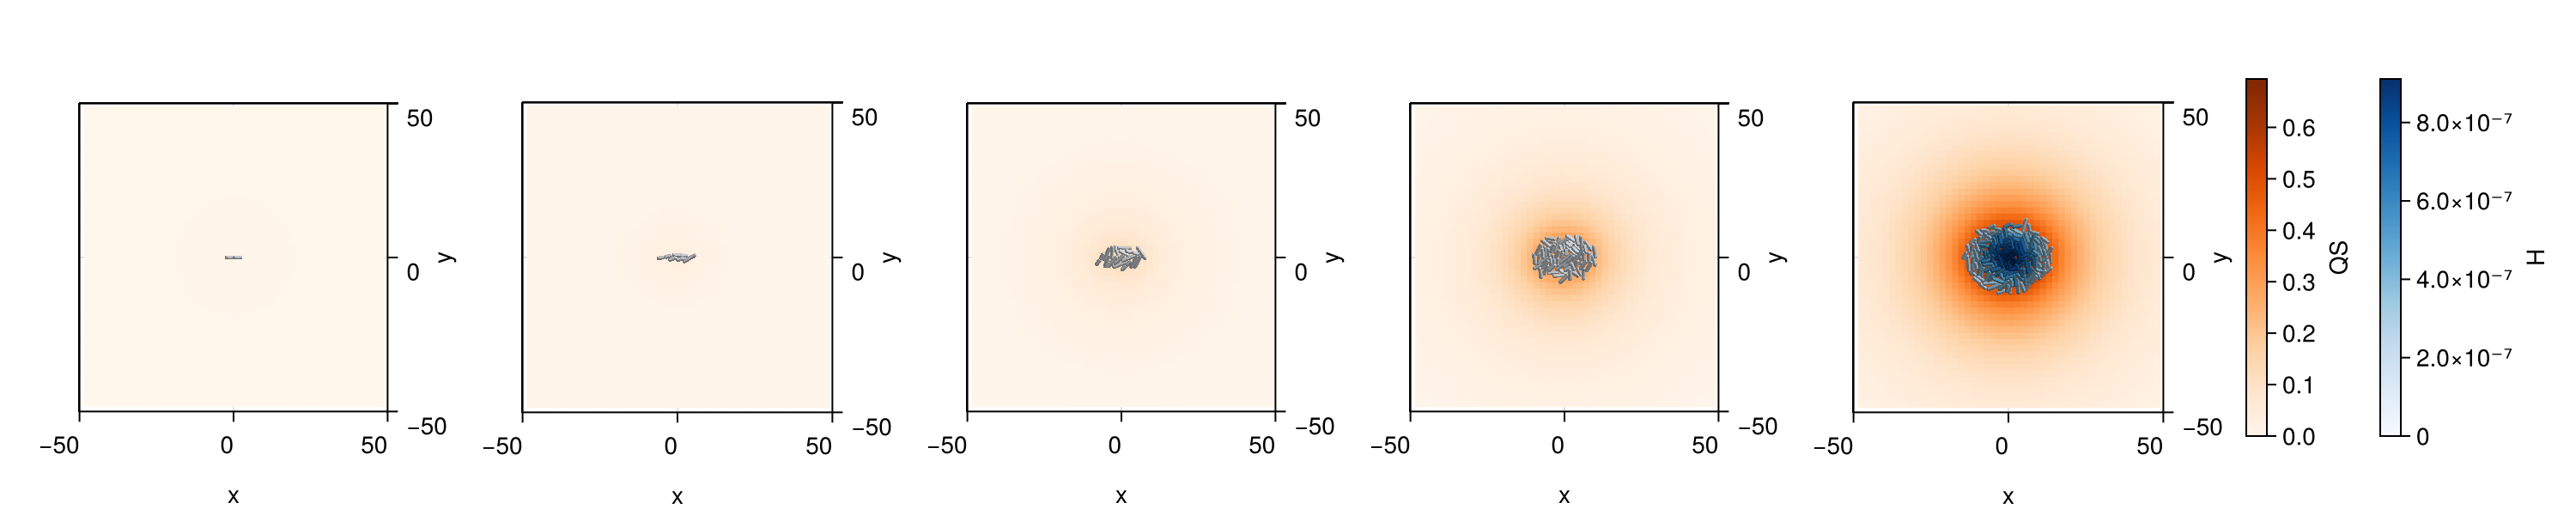

CairoMakie.Screen{IMAGE}


In [199]:
colormap=:Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
colorrange_h = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    # com_load[j][:type],
    com_load[j][:dg],
    colorrange = colorrange_h,
    colormap=:Blues
    )

    xlims!(-50,50)
    ylims!(-50,50)
end
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)
Colorbar(fig[1, length(js) + 2],
    colormap = :Blues,
    colorrange = colorrange_h,
    label = "H"
)
display(fig)

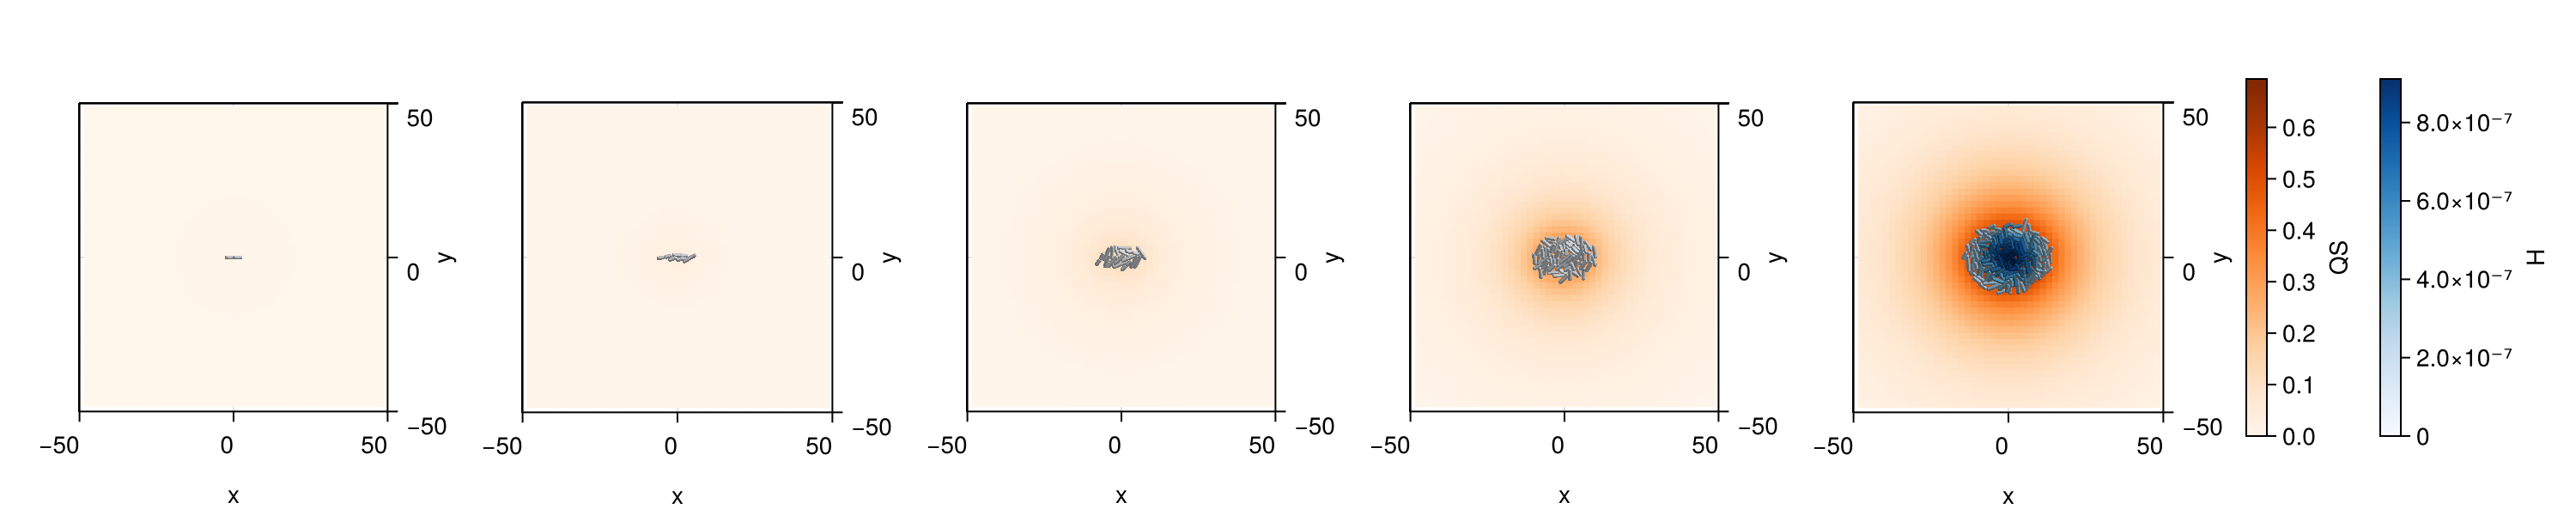

CairoMakie.Screen{IMAGE}


In [200]:
colormap=:Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
colorrange_h = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg] .+ com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    # com_load[j][:type],
    com_load[j][:dg],
    colorrange = colorrange_h,
    colormap=:Blues
    )

    xlims!(-50,50)
    ylims!(-50,50)
end
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)
Colorbar(fig[1, length(js) + 2],
    colormap = :Blues,
    colorrange = colorrange_h,
    label = "H"
)
display(fig)

In [201]:
bringFromPlatform!(com)

idmax=findfirst(x -> x == maximum(com.x), com.x)
com.type[idmax] = 1 #Change the type of the first cell to 1, so it can be identified as the first cell

idmax=findfirst(x -> x == maximum(com.y), com.y)
com.type[idmax] = 2 #Change the type of the first cell to 1, so it can be identified as the first cell

idmax=findfirst(x -> x == minimum(com.x), com.x)
com.type[idmax] = 3 #Change the type of the first cell to 1, so it can be identified as the first cell

idmax=findfirst(x -> x == minimum(com.y), com.y)
com.type[idmax] = 4 #Change the type of the first cell to 1, so it can be identified as the first cell

4

In [202]:

prev_steps=steps
steps=Int(round(14/com.dt))

loadToPlatform!(com,preallocateAgents=N)


for step in 1+prev_steps:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


Step 81000 N: 144
Step 82000 N: 148
Step 83000 N: 154
Step 84000 N: 157
Step 85000 N: 161
Step 86000 N: 166
Step 87000 N: 168
Step 88000 N: 173
Step 89000 N: 177
Step 90000 N: 184
Step 91000 N: 191
Step 92000 N: 197
Step 93000 N: 211
Step 94000 N: 212
Step 95000 N: 216
Step 96000 N: 219
Step 97000 N: 225
Step 98000 N: 229
Step 99000 N: 235
Step 100000 N: 239
Step 101000 N: 245
Step 102000 N: 255
Step 103000 N: 265
Step 104000 N: 279
Step 105000 N: 291
Step 106000 N: 299
Step 107000 N: 305
Step 108000 N: 314
Step 109000 N: 320
Step 110000 N: 332
Step 111000 N: 344
Step 112000 N: 357
Step 113000 N: 367
Step 114000 N: 378
Step 115000 N: 390
Step 116000 N: 404
Step 117000 N: 419
Step 118000 N: 424
Step 119000 N: 433
Step 120000 N: 443
Step 121000 N: 451
Step 122000 N: 454
Step 123000 N: 454
Step 124000 N: 455
Step 125000 N: 458
Step 126000 N: 460
Step 127000 N: 463
Step 128000 N: 470
Step 129000 N: 478
Step 130000 N: 486
Step 131000 N: 492
Step 132000 N: 494
Step 133000 N: 501
Step 134000 

In [203]:
com_load,times=load_parameters_log("parameters_QS_cap.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:alpha_H => Any[10000.0], :W => Any[-1.1572538880595454e-7, -1.1572538880595431e-7], :fx => Any[-0.7538184887457948, 0.7538184887457942], :delta_q => Any[0.1], :x => Any[-1.3107217987494026, 1.3107217987494026], :K_p => Any[0.1], :delta_H => Any[1000.0], :σlTarget => Any[1.0], :theta => Any[-3.8968911258673107e-8, -3.896891125867309e-8], :q => Any[Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 2.477009522205595e-49, 1.4564680582534003e-48, 8.169925496149842e-48, 4.489624131363807e-47, 2.41794025010118e-46, 1.2757463373920186e-45, 6.591589818632551e-45, 3.3338048660544746e-44, 1.6497742660751236e-43  …  4.233598830866373e-43, 8.741249388039191e-44, 1.7657173003126246e-44, 3.4909448355302323e-45, 6.7580642958384194e-46, 1.2815502366458026e-46, 2.38145611011103e-47, 4.33458300557621e-48, 7.517356421226614e-49, 0.0], Any[0.0, 1.4694996647584567e-48, 8.642364486521961e-48, 4.848928878

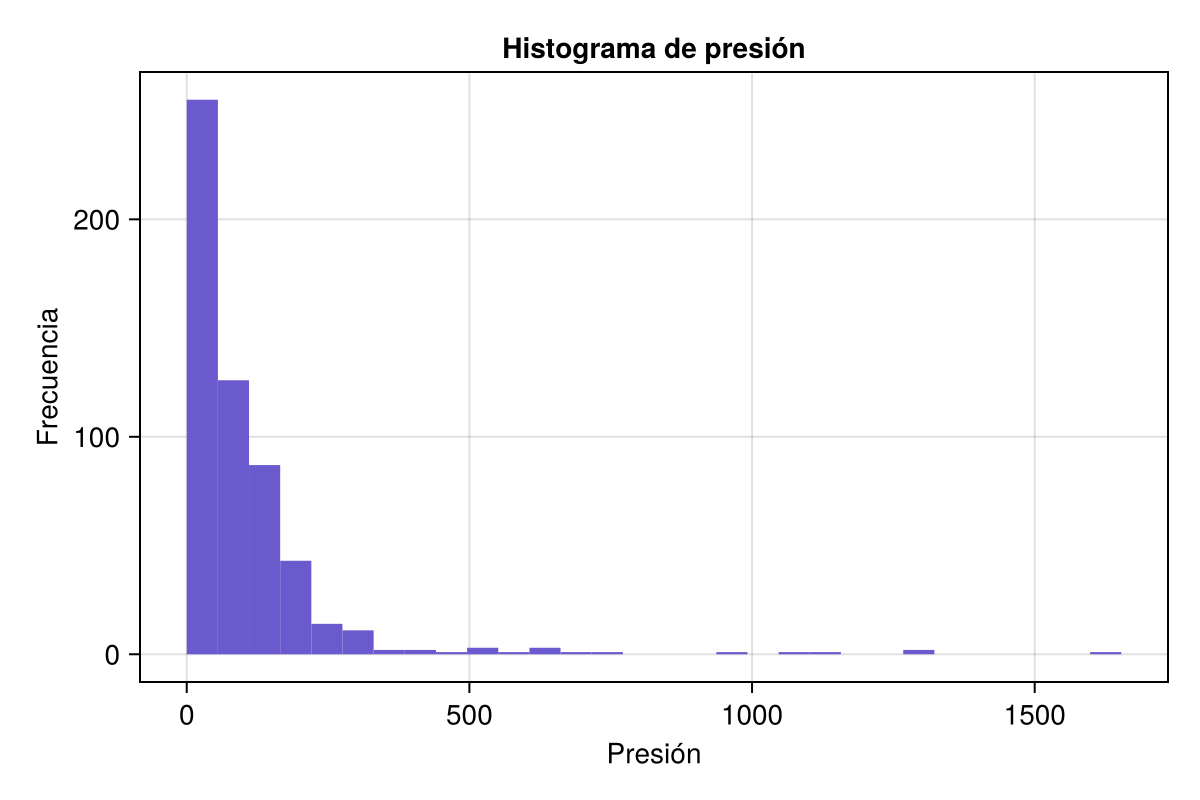

In [213]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

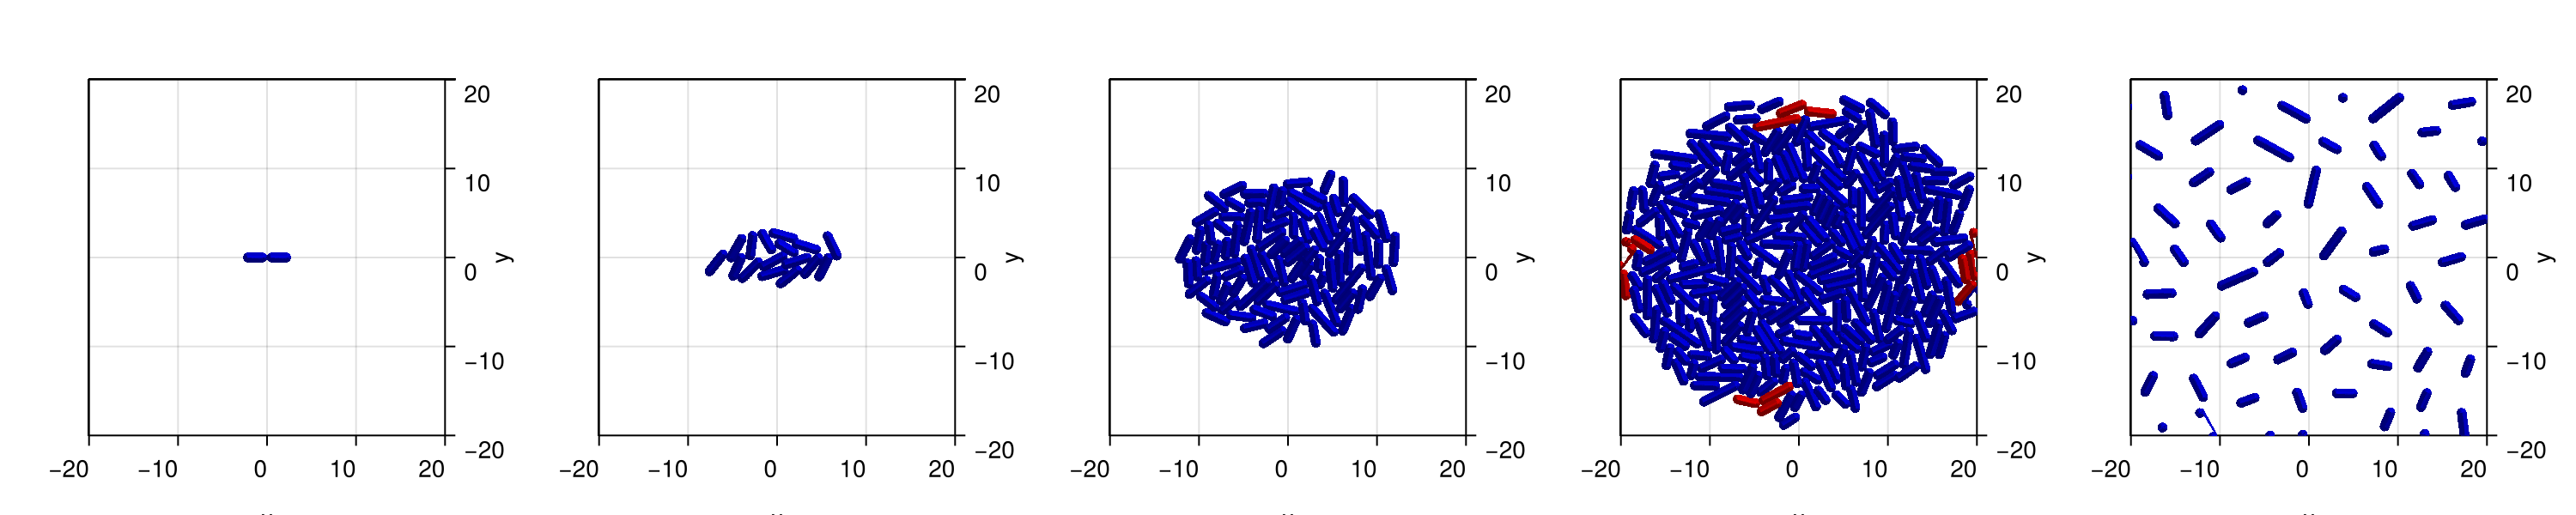

CairoMakie.Screen{IMAGE}


In [214]:
# Colormap común y colorrange fijo
# colormap = :viridis
# colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotMixedAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-20,20)
    ylims!(-20,20)
end

# Añadir colorbar común al final
# Colorbar(fig[1, length(js) + 1],
#     colormap = colormap,
#     colorrange = colorrange,
#     label = "QS"
# )

display(fig)

In [206]:
function plotMixedAgents!(ax, x, y, d, l, angle, type, p; kargs...)
    # Diccionario de tipos a colormaps (puedes extenderlo con más tipos y colores)
    colormap_dict = Dict(
        0 => :Blues,
        1 => :Reds,
        2 => :Greens,
        3 => :Oranges,
        4 => :Purples,
        5 => :Greys
    )

    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)
        # Colormap según tipo, o uno genérico si no está definido
        colormap = get(colormap_dict, ti, :viridis)

        # Color numérico según p
        colorval = pi

        # Esferas en los extremos
        for dx in (-1, 1)
            meshscatter!(ax,
                [xi + dx * li/2 * cos(ai)],
                [yi + dx * li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = colorval,
                colormap = colormap,
                kargs...
            )
        end

        # Cuerpo alargado
        meshscatter!(ax,
            [xi],
            [yi];
            marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
            markersize = [Point3f(li, di/2, di/2)],
            rotation = [ai],
            color = colorval,
            colormap = colormap,
            kargs...
        )
    end
    return
end


plotMixedAgents! (generic function with 1 method)

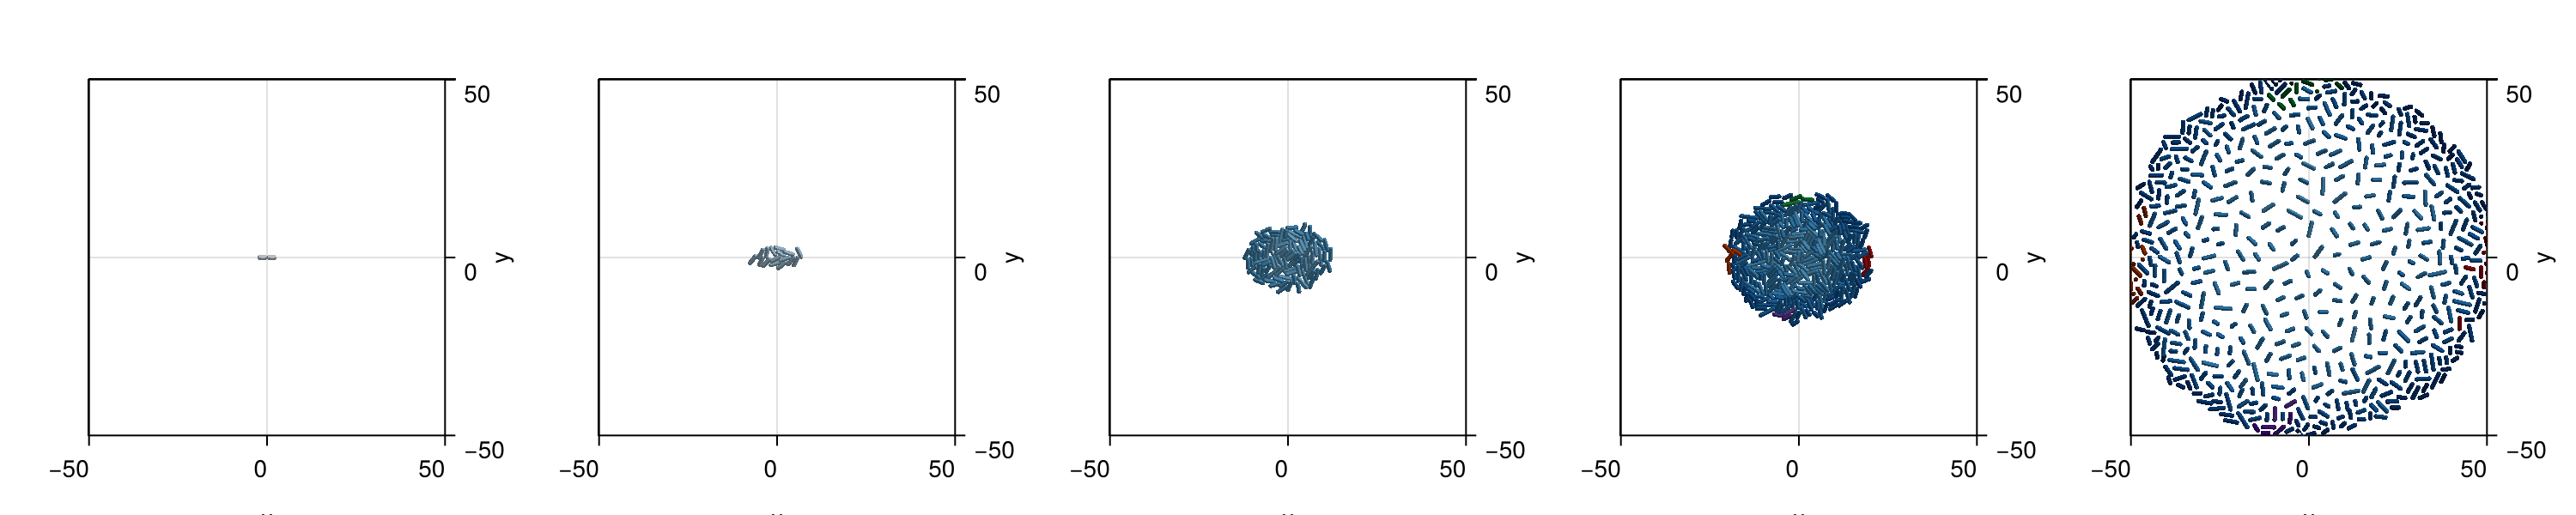

CairoMakie.Screen{IMAGE}


In [207]:
# Colormap común y colorrange fijo
# colormap = :viridis
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:generation]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotMixedAgents!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:generation],
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
# Colorbar(fig[1, length(js) + 1],
#     colormap = colormap,
#     colorrange = colorrange,
#     label = "QS"
# )

display(fig)

In [208]:
length(com_load[end][:x])

556

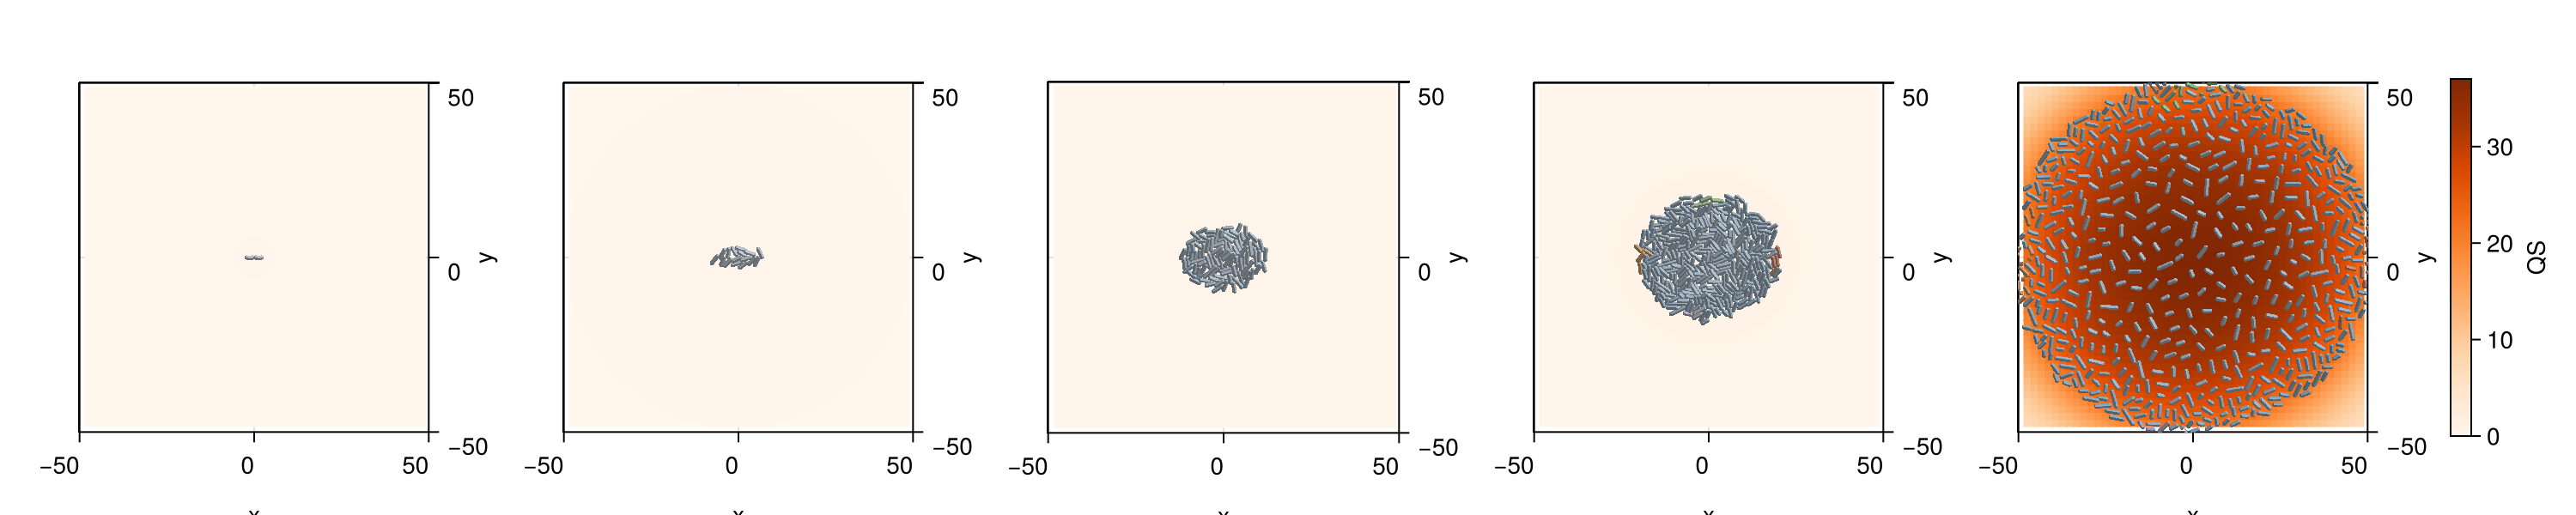

CairoMakie.Screen{IMAGE}


In [209]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotMixedAgents!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:generation],
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

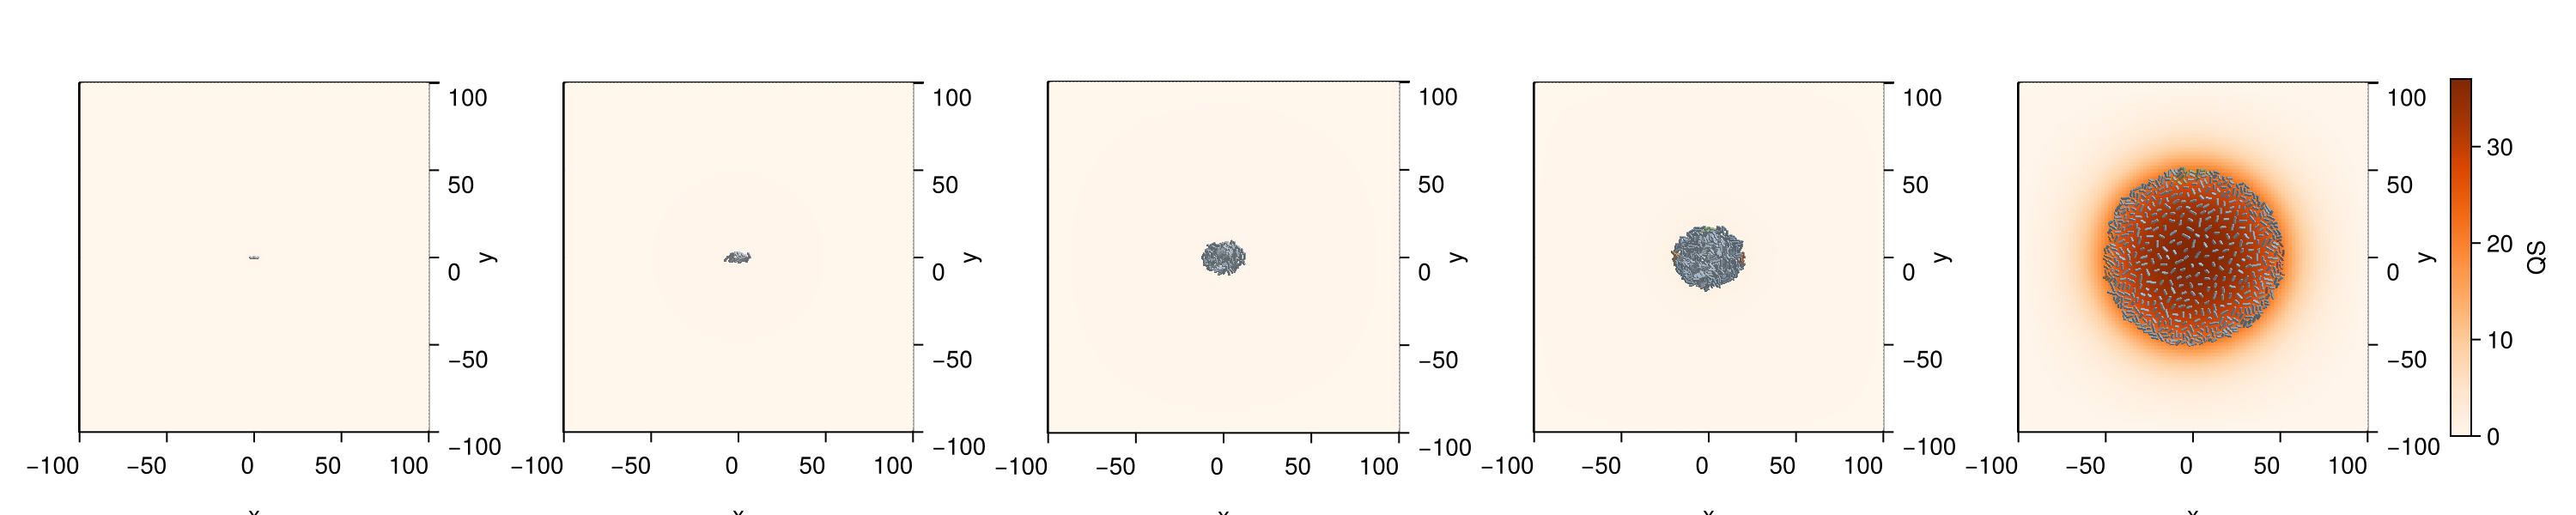

CairoMakie.Screen{IMAGE}


In [210]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotMixedAgents!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:generation],
    colorrange = colorrange
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

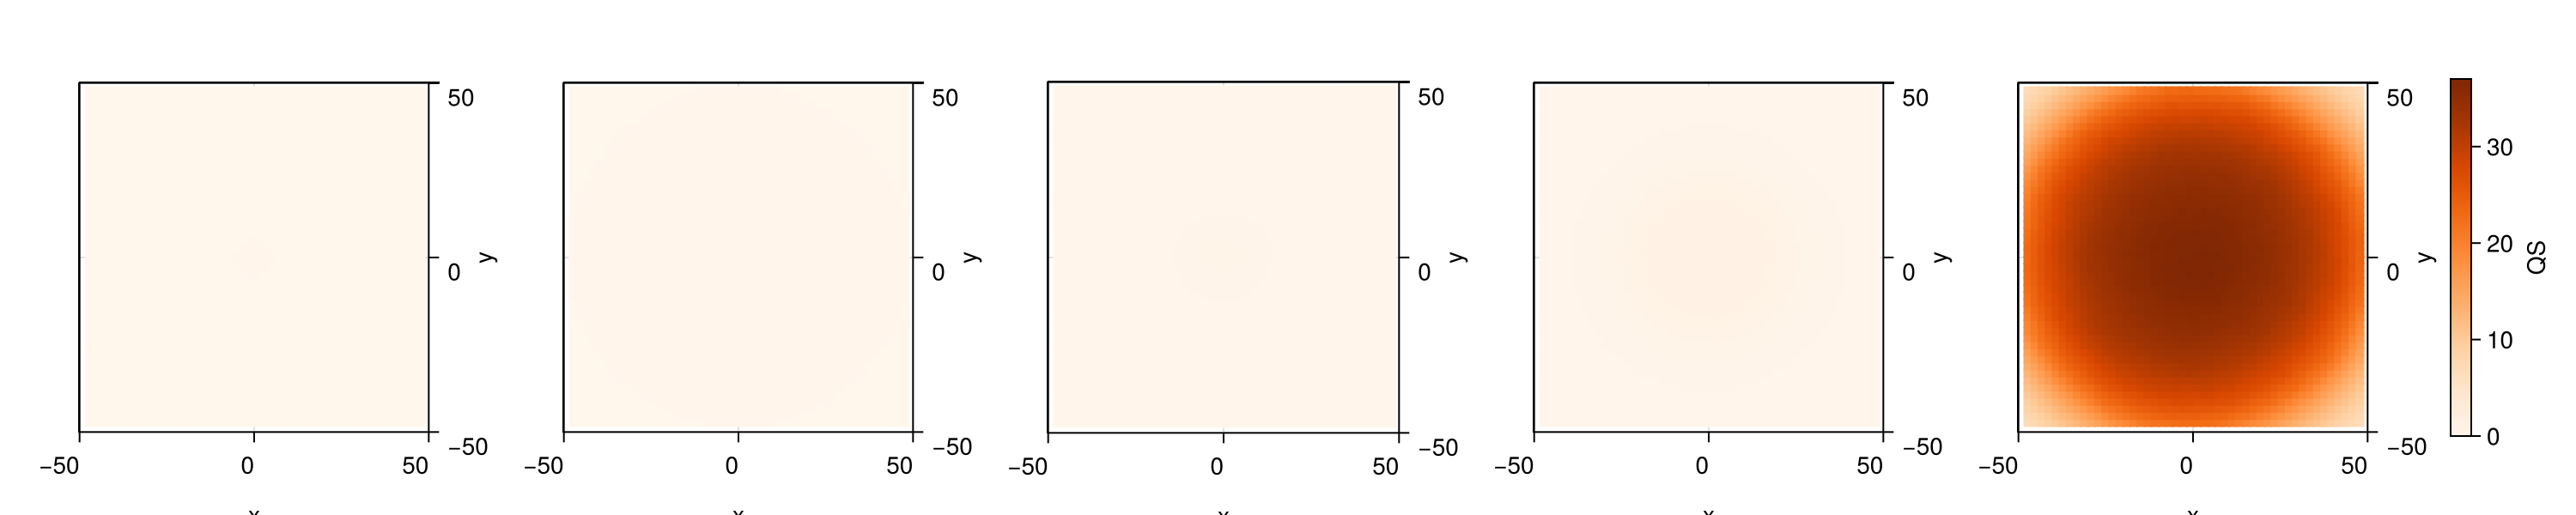

CairoMakie.Screen{IMAGE}


In [211]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:generation],
    # colorrange = colorrange
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

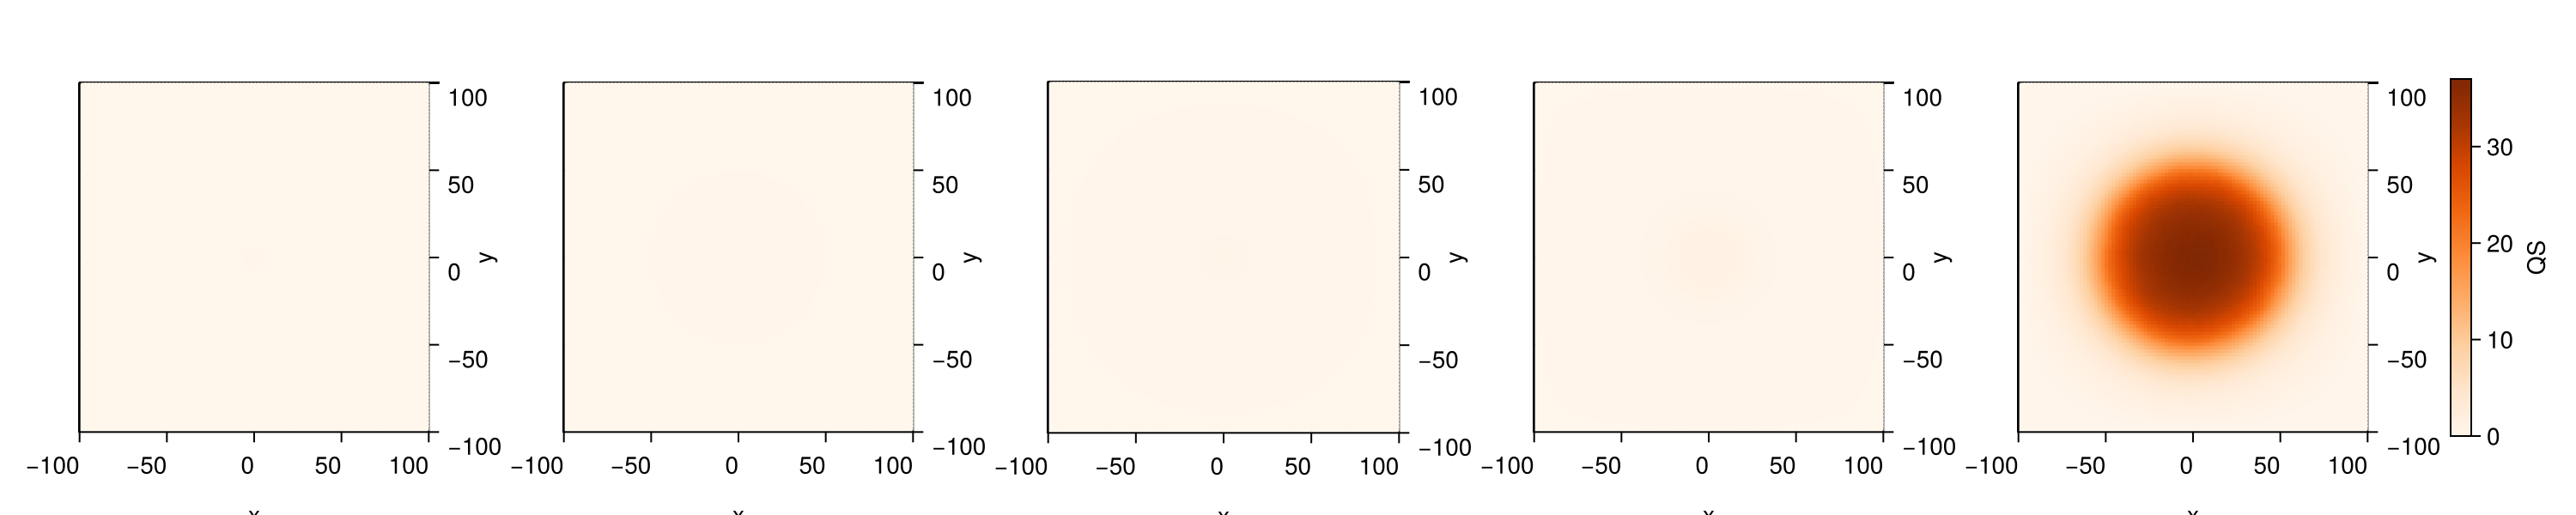

CairoMakie.Screen{IMAGE}


In [212]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:generation],
    # colorrange = colorrange
    # )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

In [215]:
function plot_evolution_by_type_from_positions(com)
    colormap_dict = Dict(
        0 => :Blues,
        1 => :Reds,
        2 => :Greens,
        3 => :Oranges,
        4 => :Purples,
        5 => :Greys
    )

    tipos = unique(com[end][:type])
    tipos = sort(tipos)[2:end]

    first_gen = Dict{Int, NamedTuple}()

    for t in sort(collect(keys(com)))
        for (i, ti) in enumerate(com[t][:type])
            if !(ti in keys(first_gen))
                first_gen[ti] = (
                    tiempo = t,
                    index = i,
                    x0 = com[t][:x][i],
                    y0 = com[t][:y][i]
                )
            end
        end
    end

    fig = Figure()
    ax = Axis(fig[1, 1], 
            xlabel = "θ",
            ylabel = "r",
            yreversed = true,
            )

    for t in sort(collect(keys(com)))
        com_t = com[t]

        for ti in tipos
            indices = findall(com_t[:type] .== ti)
            if isempty(indices)
                continue
            end

            f = first_gen[ti]
            x0, y0 = f.x0, f.y0
            gen0 = f.tiempo

            xs = com_t[:x][indices]
            ys = com_t[:y][indices]
            gens = fill(t - gen0, length(indices))

            distances = sqrt.((xs).^2 .+ (ys).^2)

            # Ángulo relativo calculado por desplazamiento
            angles = atan.(ys, xs)  



            colormap = haskey(colormap_dict, ti) ? colormap_dict[ti] : error("Tipo $ti no tiene colormap definido")

            scatter!(ax, angles, distances;
                color = gens,
                colormap = colormap,
                markersize = 10,
                label = "Tipo $ti",
                colorrange = (0, length(com)),
            )
        end
    end

    # axislegend(ax)
    return fig
end


plot_evolution_by_type_from_positions (generic function with 1 method)

In [217]:
function plot_evolution(com)
    colormap_dict = Dict(
        0 => :Blues,
        1 => :Reds,
        2 => :Greens,
        3 => :Oranges,
        4 => :Purples,
        5 => :Greys
    )

    tipos = unique(com[end][:type])
    tipos = sort(tipos)[2:end]

    first_gen = Dict{Int, NamedTuple}()

    for t in sort(collect(keys(com)))
        for (i, ti) in enumerate(com[t][:type])
            if !(ti in keys(first_gen))
                first_gen[ti] = (
                    tiempo = t,
                    index = i,
                    x0 = com[t][:x][i],
                    y0 = com[t][:y][i]
                )
            end
        end
    end

    fig = Figure(backgroundcolor = :black)  # Fondo negro

    ax = Axis(
        fig[1, 1],
        xlabel = "θ",  # Letra griega
        ylabel = "r",
        yreversed = true,
        backgroundcolor = :black,
        xlabelcolor = :white,
        ylabelcolor = :white,
        xticklabelcolor = :white,
        yticklabelcolor = :white,
        xtickcolor = :white,
        ytickcolor = :white,
        bottomspinecolor = :white,
        leftspinecolor = :white,
        rightspinecolor = :white,
        topspinecolor = :white
    )

    for t in sort(collect(keys(com)))
        com_t = com[t]

        for ti in tipos
            indices = findall(com_t[:type] .== ti)
            if isempty(indices)
                continue
            end

            f = first_gen[ti]
            x0, y0 = f.x0, f.y0
            gen0 = f.tiempo

            xs = com_t[:x][indices]
            ys = com_t[:y][indices]
            gens = fill(t - gen0, length(indices))

            distances = sqrt.((xs).^2 .+ (ys).^2)
            angles = atan.(ys, xs)

            colormap = get(colormap_dict, ti, :viridis)

            scatter!(ax, angles, distances;
                color = gens,
                colormap = colormap,
                markersize = 10,
                label = "Tipo $ti",
                colorrange = (0, length(com)),
            )
        end
    end

    return fig
end


plot_evolution (generic function with 1 method)

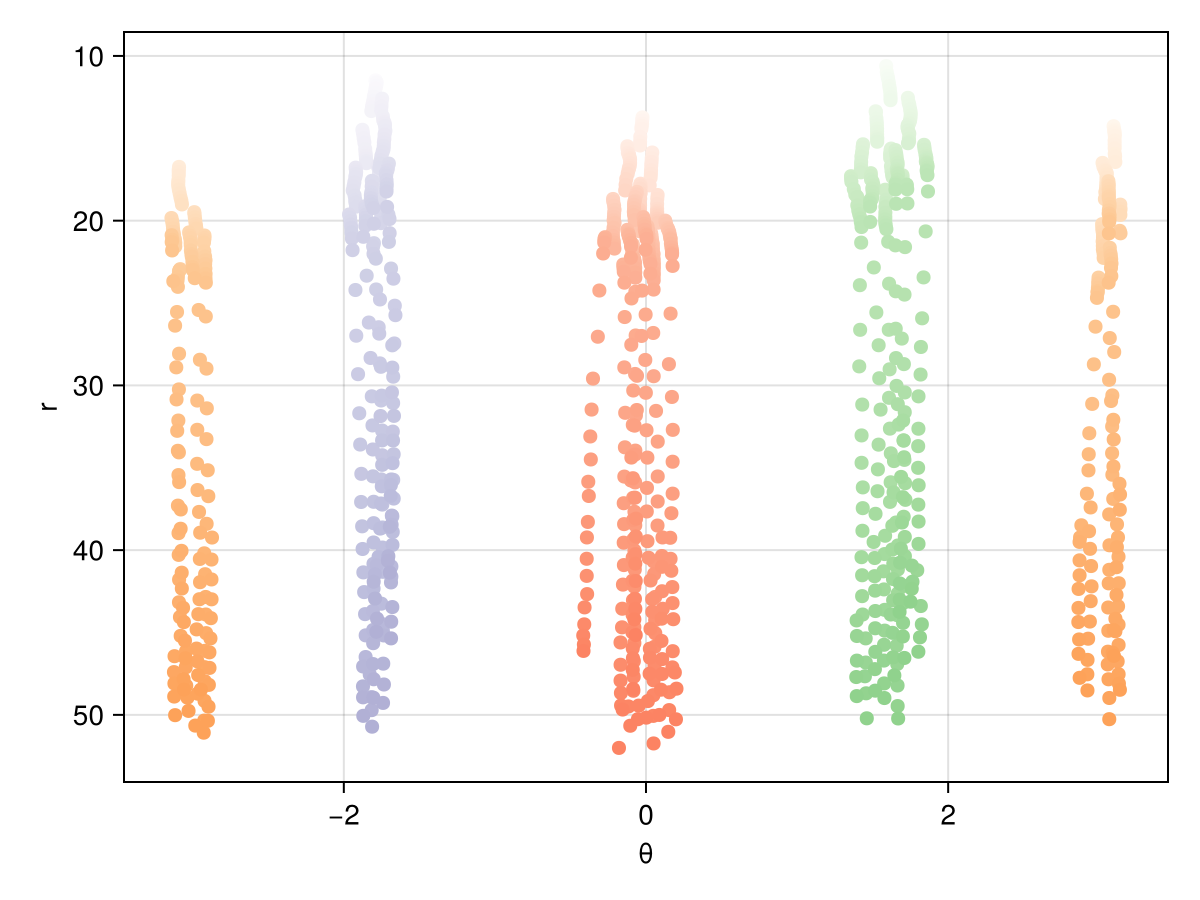

In [219]:
plot_evolution_by_type_from_positions(com_load)

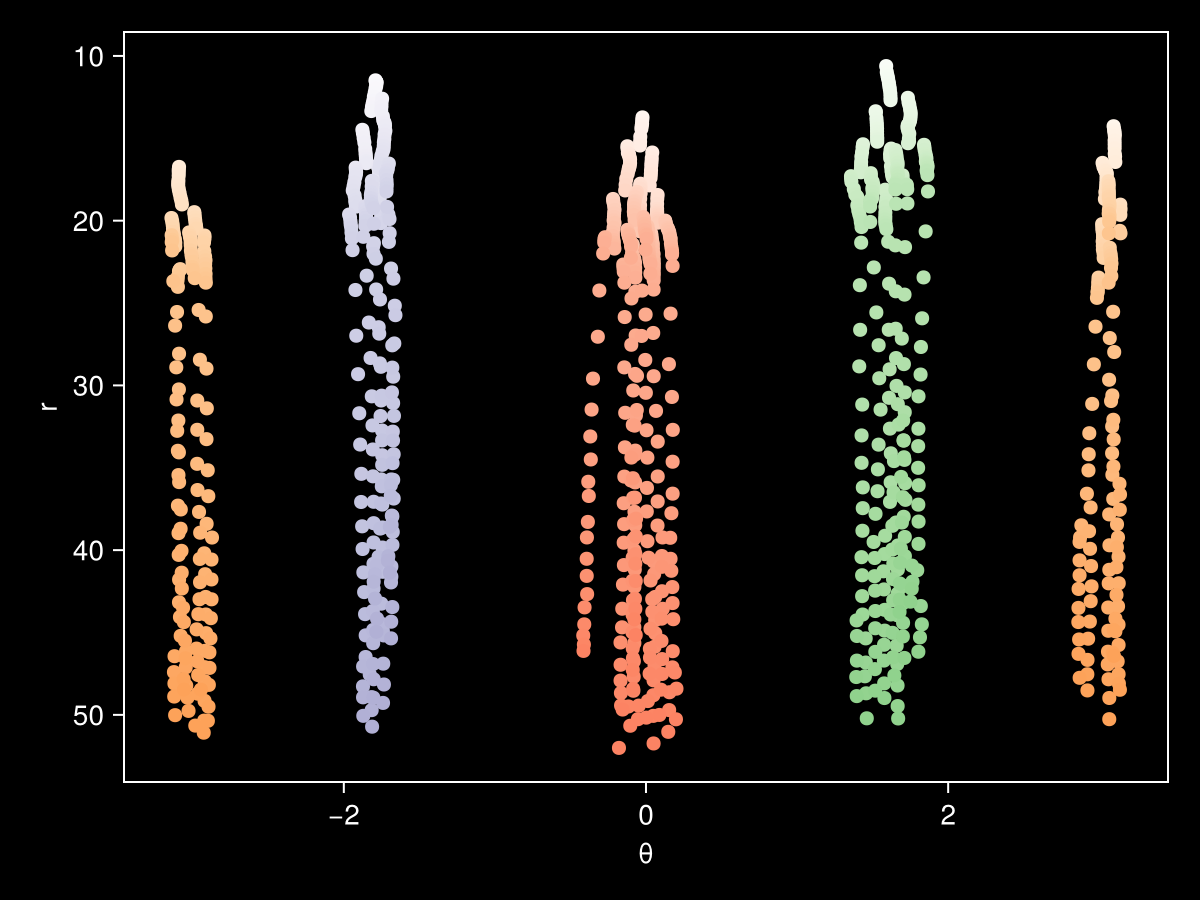

In [220]:
plot_evolution(com_load)


In [ ]:

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())


colorrange = (0.0,  maximum(maximum(p -> maximum(p[:generation]), com_load)))

Makie.record(fig, "bacterias_linage.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
   
    plotMixedAgents!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:type],
        com_load[j][:generation],
        colorrange = colorrange
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_linage_k01_g1_8_18.mp4"

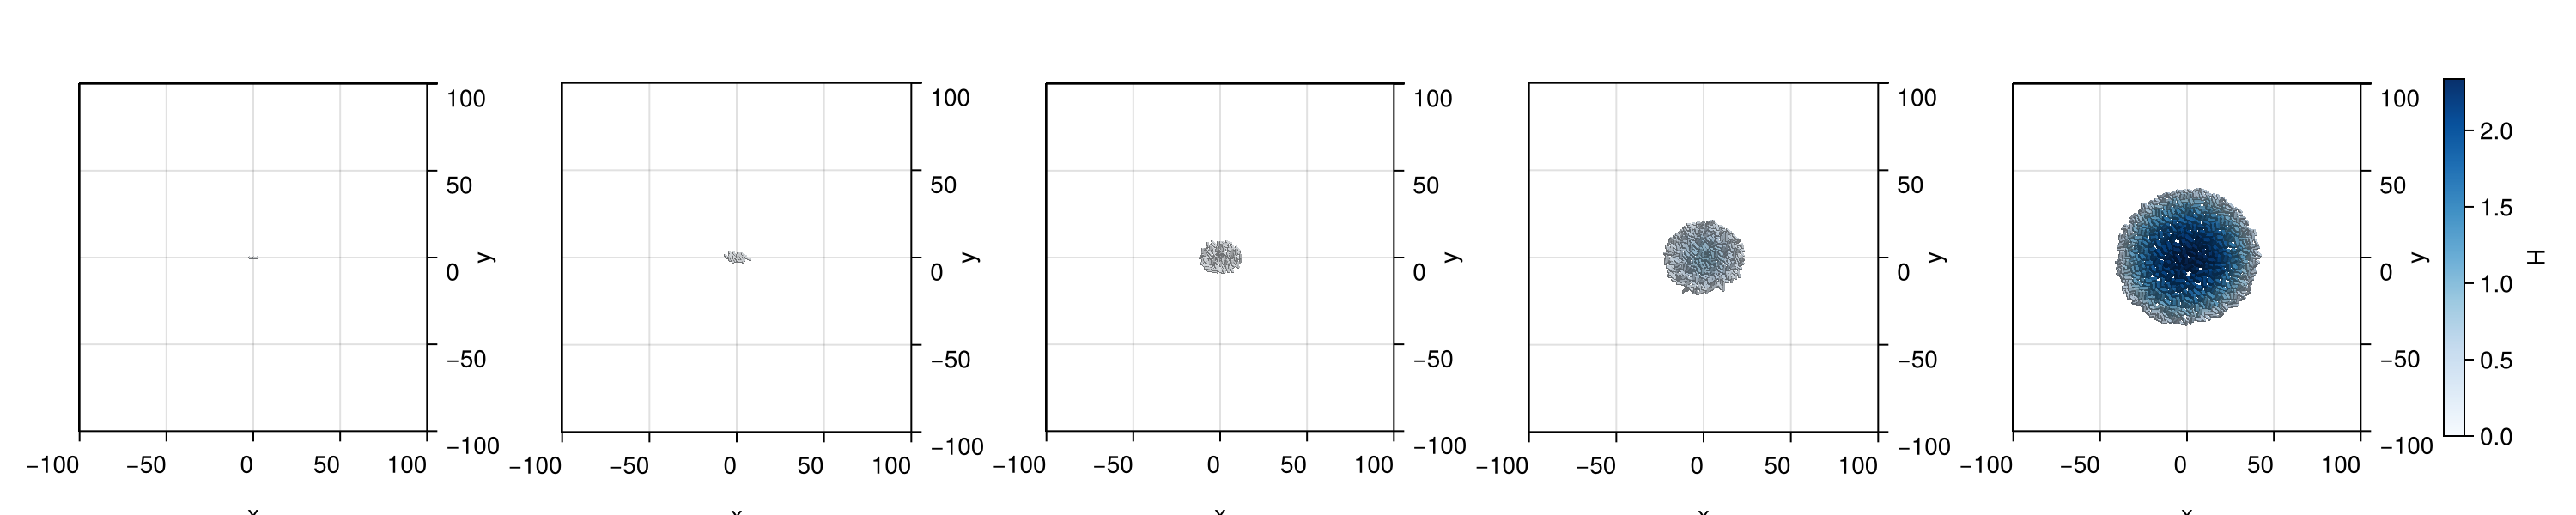

CairoMakie.Screen{IMAGE}


In [168]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg] .+ com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)

display(fig)

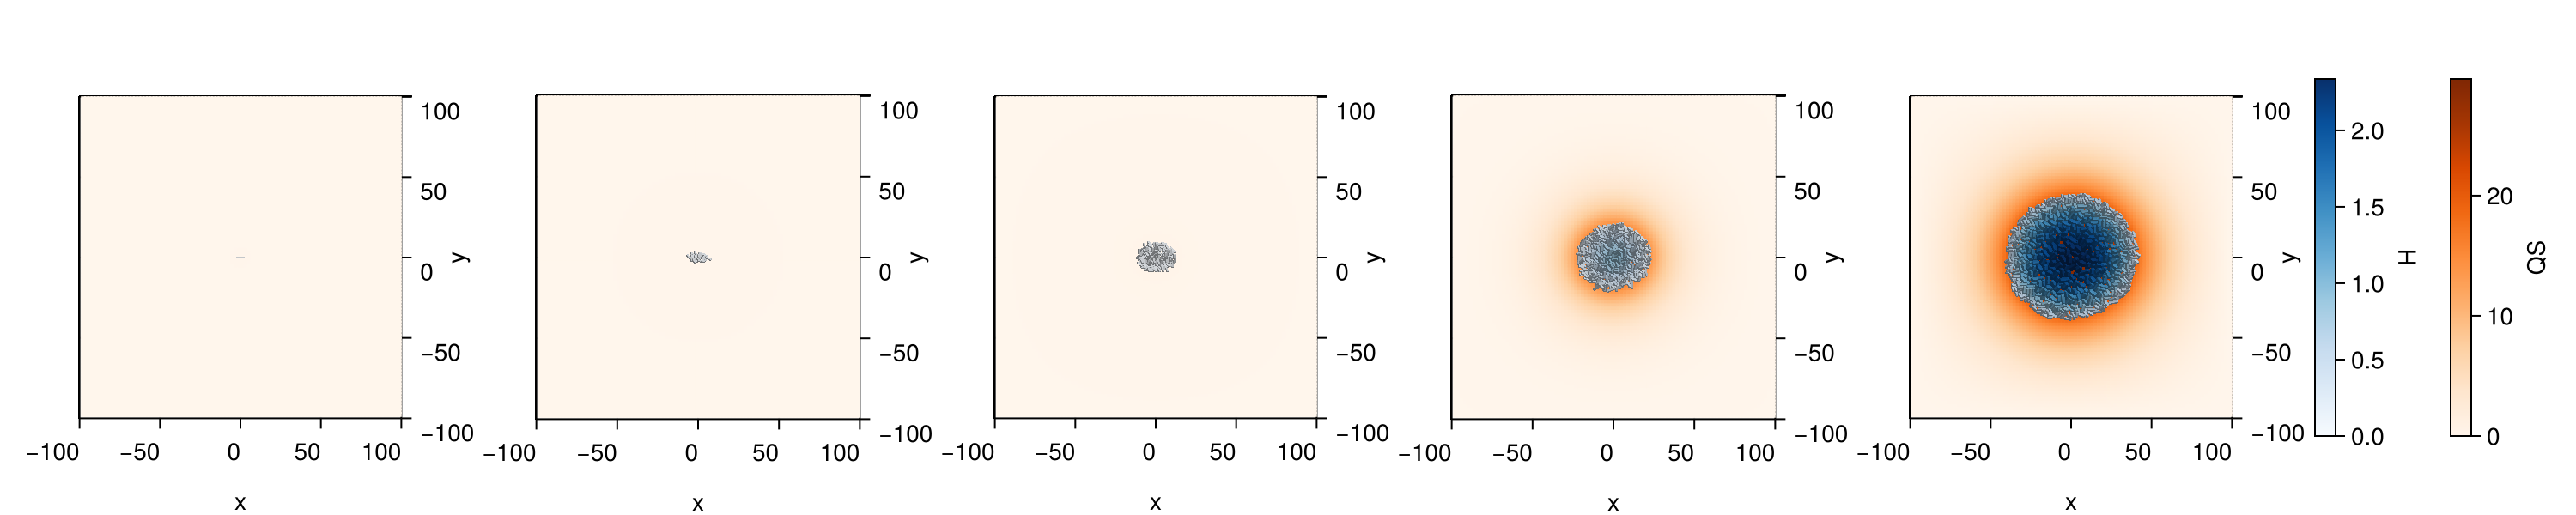

CairoMakie.Screen{IMAGE}


In [169]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Colormap común y colorrange fijo
colormap_q = :Oranges
colorrange_q = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg] .+ com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)
Colorbar(fig[1, length(js) + 2],
    colormap = colormap_q,
    colorrange = colorrange_q,
    label = "QS"
)

display(fig)

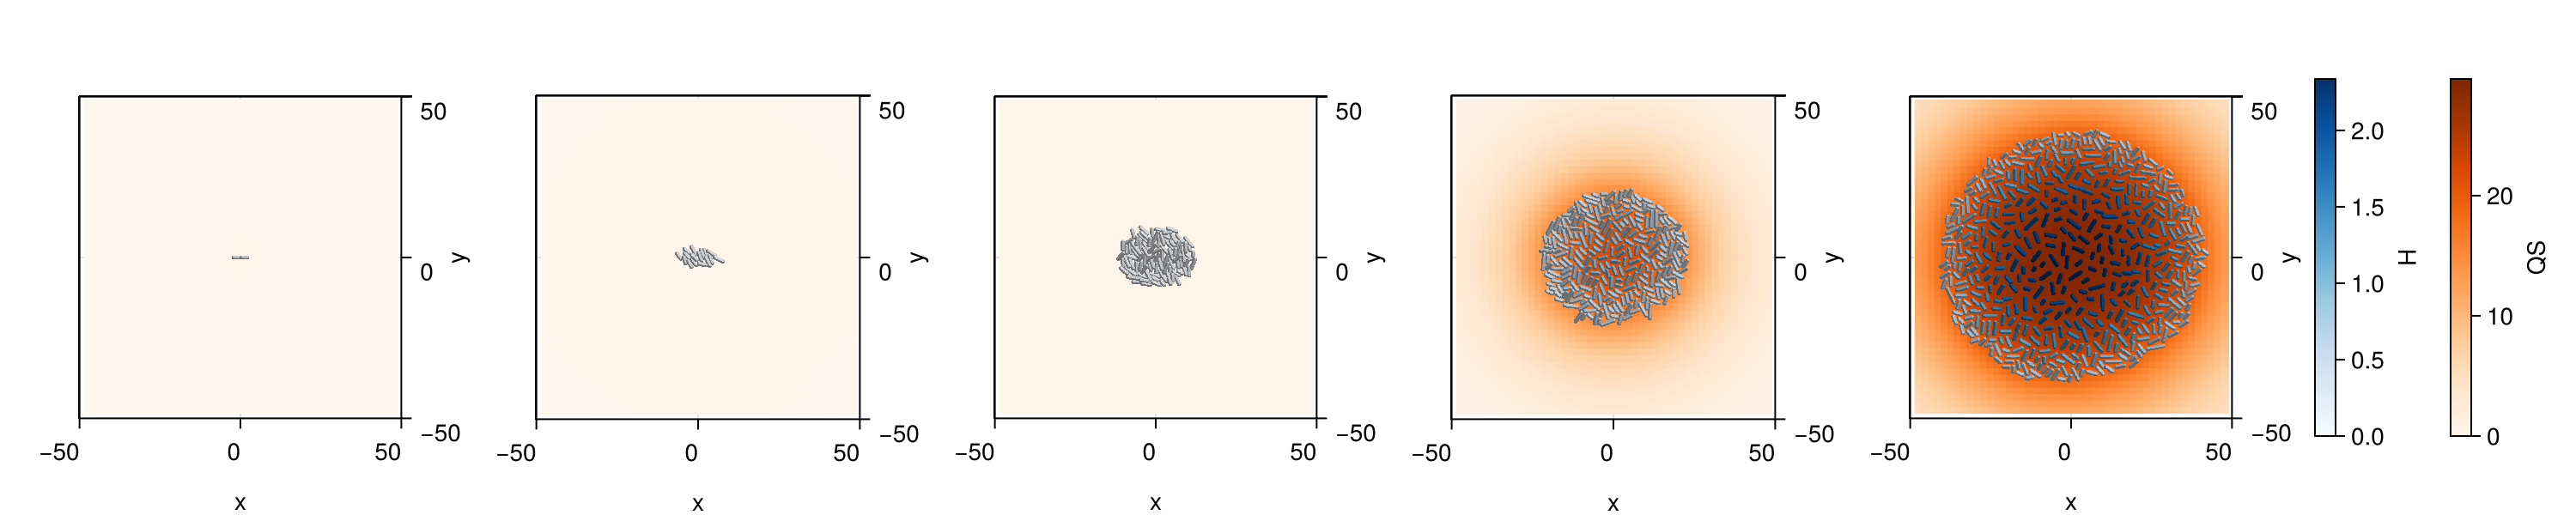

CairoMakie.Screen{IMAGE}


In [170]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Colormap común y colorrange fijo
colormap_q = :Oranges
colorrange_q = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)
Colorbar(fig[1, length(js) + 2],
    colormap = colormap_q,
    colorrange = colorrange_q,
    label = "QS"
)

display(fig)

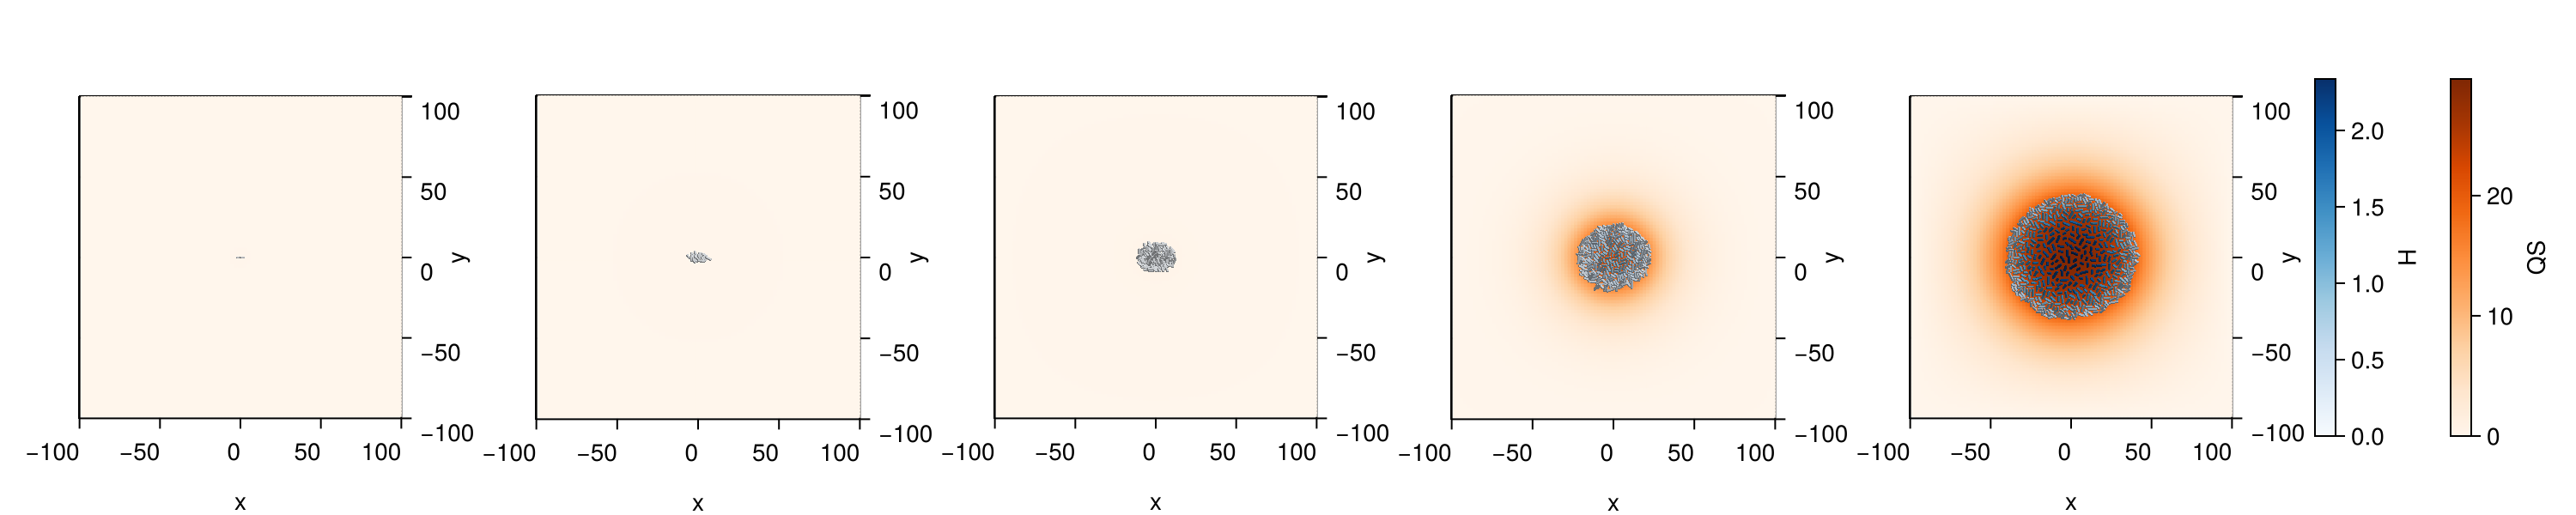

CairoMakie.Screen{IMAGE}


In [171]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Colormap común y colorrange fijo
colormap_q = :Oranges
colorrange_q = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)
Colorbar(fig[1, length(js) + 2],
    colormap = colormap_q,
    colorrange = colorrange_q,
    label = "QS"
)

display(fig)

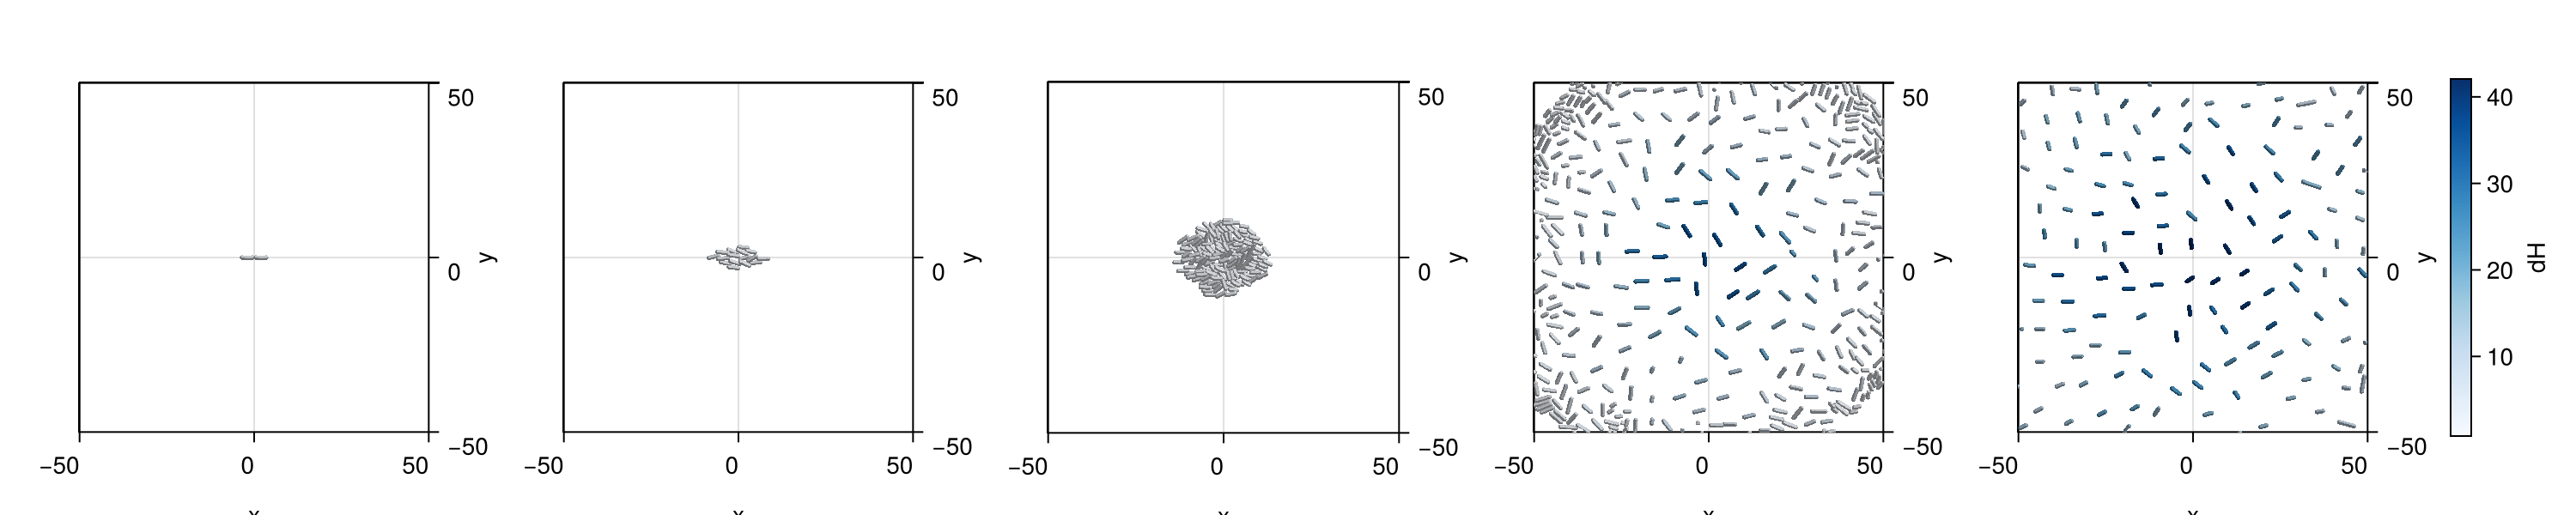

CairoMakie.Screen{IMAGE}


In [ ]:
# # Colormap común y colorrange fijo
# colormap = :Blues
# colorrange = (0.8,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



# fig = Figure(size=(1500,300))

# js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

# for (i,j) in enumerate(js)
#     ax = Axis3(fig[1,i],
#                 azimuth=3*π/2,
#                 elevation=π/2,
#                 zlabelvisible=false,
#                 zticklabelsvisible=false,
#                 zgridvisible=false,
#                 zspinesvisible=false
#             )
#     # m = heatmap!(ax,
#     #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
#     #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
#     #             Float64.(hcat(com_load[j][:q]...)),
#     #             colormap = colormap,
#     #             colorrange = colorrange
#     #         )
    

#     plotAgents2D!(
#     ax,
#     com_load[j][:x],
#     com_load[j][:y],
#     com_load[j][:d],
#     com_load[j][:l],
#     com_load[j][:theta],
#     com_load[j][:dg],
#     colormap=:Blues,
#     colorrange = colorrange,
#     )

#     xlims!(-50,50)
#     ylims!(-50,50)
# end

# # Añadir colorbar común al final
# Colorbar(fig[1, length(js) + 1],
#     colormap = colormap,
#     colorrange = colorrange,
#     label = "dH"
# )

# display(fig)

In [ ]:

# # Configuración general
# colormap = Reverse(:Blues)
# colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# # Crear figura y ejes
# fig = Figure(size = (800, 600))
# grid = fig[1, 1] = GridLayout()
# ax = Axis(grid[1, 1]; aspect = DataAspect())
# Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez

# n_repeats = 1  # Número de veces que repetimos cada frame
# framerate = 1  # 10 fps → cada frame se mantiene 1 segundo

# Makie.record(fig, "bacterias_cap.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
#     j = ceil(Int, i / n_repeats)  # Frame real   
#     Makie.empty!(ax)
#     # Preparar heatmap observable para actualizar luego
#     # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
#     # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
#     # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

#     # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

#     plotAgents2D!(
#         ax,
#         com_load[j][:x],
#         com_load[j][:y],
#         com_load[j][:d],
#         com_load[j][:l],
#         com_load[j][:theta],
#         com_load[j][:dg],
#         colorrange = colorrange,
#         colormap= colormap,
#     )


#     xlims!(ax, -50, 50)
#     ylims!(ax, -50, 50)
# end


"bacterias_cap.mp4"

In [ ]:

# # Configuración general
# colormap = Reverse(:Blues)
# colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# # Crear figura y ejes
# fig = Figure(size = (800, 600))
# grid = fig[1, 1] = GridLayout()
# ax = Axis(grid[1, 1]; aspect = DataAspect())
# Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez


# n_repeats = 10  # Número de veces que repetimos cada frame
# framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

# Makie.record(fig, "bacterias_cap_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
#     j = ceil(Int, i / n_repeats)  # Frame real  
#     Makie.empty!(ax)
#     # Preparar heatmap observable para actualizar luego
#     # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
#     # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
#     # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

#     # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

#     plotAgents2D!(
#         ax,
#         com_load[j][:x],
#         com_load[j][:y],
#         com_load[j][:d],
#         com_load[j][:l],
#         com_load[j][:theta],
#         com_load[j][:dg],
#         colorrange = colorrange,
#         colormap= colormap,
#     )


#     xlims!(ax, -100, 100)
#     ylims!(ax, -100, 100)
# end


"bacterias_cap_zoom.mp4"

In [168]:
colorrange_q

(0, 9.984126032780424)

In [221]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="H")  # una vez
Colorbar(grid[1, 3], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez


n_repeats = 1  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "pushing_QS_bac.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)

    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap = colormap
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"pushing_QS_bac.mp4"

In [222]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="H")  # una vez
Colorbar(grid[1, 3], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez


n_repeats = 1  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "pushing_QS_bac_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)

    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap = colormap
    )


    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"pushing_QS_bac_zoom.mp4"

In [224]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="H")  # una vez
# Colorbar(grid[1, 3], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez


n_repeats = 1  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "pushing_bac_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)

    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap_q,
    #             colorrange = colorrange_q
    #         )

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap = colormap
    )


    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"pushing_bac_zoom.mp4"

In [ ]:
# # Configuración general
# colormap = Reverse(:Blues)
# colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# # Crear figura y ejes
# fig = Figure(size = (800, 600))
# grid = fig[1, 1] = GridLayout()
# ax = Axis(grid[1, 1]; aspect = DataAspect())
# Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="H")  # una vez



# n_repeats = 1  # Número de veces que repetimos cada frame
# framerate = 1  # 10 fps → cada frame se mantiene 1 segundo

# Makie.record(fig, "bacterias_cap_pga_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
#     j = ceil(Int, i / n_repeats)  # Frame real

#     Makie.empty!(ax)

#     plotAgents2D!(
#         ax,
#         com_load[j][:x],
#         com_load[j][:y],
#         com_load[j][:d],
#         com_load[j][:l],
#         com_load[j][:theta],
#         com_load[j][:dg],
#         colormap = colormap,
#         colorrange = colorrange
#     )

#     xlims!(ax, -100, 100)
#     ylims!(ax, -100, 100)
# end


"bacterias_cap_pga_zoom.mp4"